In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

from nltk.tokenize.treebank import TreebankWordDetokenizer
%matplotlib inline

# Downloading and Preprocessing the Data

In [25]:
df = pd.read_csv('../data/ner_dataset.csv', encoding = "ISO-8859-1")
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 3119,the,NN,O
freq,1,52573,145807,887908


In [26]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [27]:
print(df['Tag'].unique())

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [28]:
tagset = df['Tag'].unique()
b_tagset = set([i for i in tagset if i.startswith("B")])

In [29]:
for tag in b_tagset:
    print(tag)
    print(np.sum(df['Tag']==tag), np.sum(df['Tag']==tag.replace('B', 'I'))) 

B-eve
308 253
B-geo
37644 7414
B-art
402 297
B-tim
20333 6528
B-nat
201 51
B-org
20143 16784
B-gpe
15870 198
B-per
16990 17251


In [30]:
df = df.fillna(method = 'ffill')

In [31]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [32]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [33]:
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [34]:
sentences = getter.sentences

In [36]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [37]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Training and Evaluating the Model

In [40]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [41]:
#Predicting on the test set.
y_pred = crf.predict(X_test)

In [42]:
f1_score = flat_f1_score(y_test, y_pred, average = 'weighted')
print(f1_score)

0.9713086049664129


In [43]:
report = flat_classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       B-art       0.48      0.12      0.20        97
       B-eve       0.52      0.30      0.38        56
       B-geo       0.86      0.91      0.89      7421
       B-gpe       0.97      0.94      0.95      3093
       B-nat       0.59      0.30      0.40        33
       B-org       0.81      0.73      0.77      4027
       B-per       0.84      0.82      0.83      3423
       B-tim       0.93      0.89      0.91      4020
       I-art       0.25      0.06      0.09        71
       I-eve       0.38      0.17      0.24        52
       I-geo       0.81      0.83      0.82      1495
       I-gpe       0.87      0.51      0.64        51
       I-nat       0.67      0.20      0.31        10
       I-org       0.83      0.77      0.80      3404
       I-per       0.84      0.91      0.87      3378
       I-tim       0.82      0.77      0.80      1253
           O       0.99      0.99      0.99    176307

    accuracy              

In [198]:
b_tagset = set([i for i in tagset if i.startswith("B")])

# Point Noise

If a label is selected to have noise added, the effect of the noise differs depending on the original label:

* The `O`s are randomly flipped to a `B-x` label
* The `B-x`is randomly flipped to a different `B-y` label (or `O`), and all of the following `I-x` are flipped as well to `I-y` (or `O`, respectively)
* The `I-x`is ignored

In [75]:
import copy, random

def flip_random_labels(y, frac=0.1):
    y_new = []
    error_array = []
    
    counter = 0
    
    for i in range(len(y)):
        error_array.append(list())
        y_new.append(list())
        change_tag = False; change_to = None
        
        for j in range(len(y[i])):
            current_tag = y[i][j]
            if current_tag == 'O' and change_tag:  # stop flipping Ix --> Iy
                change_tag = False
                
            if change_tag and (current_tag.startswith('I-')):  # Ix --> Iy if a Bx tag has been changed to By
                y_new[i].append(change_to)
                error_array[i].append(True)
                continue                
                
            if np.random.random() < frac:
                
                if current_tag == 'O':  # O --> Bx
                    new_tag = random.sample(b_tagset, 1)[0]
                    
                if current_tag in b_tagset:  # Bx --> By
                    new_tagset = b_tagset.copy()
                    new_tagset.add('O')
                    new_tagset.remove(current_tag)
                    new_tag = random.sample(new_tagset, 1)[0]
                    change_tag = True
                    change_to = new_tag.replace('B-', 'I-')
                    
                y_new[i].append(new_tag)
                error_array[i].append(True)
                
            else:  # Ignore
                
                y_new[i].append(current_tag)
                error_array[i].append(False)
        
    return y_new, error_array

In [298]:
y_train_new, error_train_array = flip_random_labels(y_train, frac=0.1)

#### Leave None Out

In [299]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)

crf.fit(X_train, y_train_new)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [300]:
#Predicting on the test set.
y_train_pred_probs = crf.predict_marginals(X_train)

In [301]:
def score_mislabeled(y_orig, y_pred_probs):
    scores = []
    for i in range(len(y_orig)):
        scores.append(list())
        for j in range(len(y_orig[i])):
            prob_dict = y_pred_probs[i][j]
            max_prob_label = max(prob_dict, key=prob_dict.get)
            if max_prob_label == y_orig[i][j]:
                scores[i].append(1 - prob_dict[max_prob_label])
            else:
                scores[i].append(prob_dict[max_prob_label]) 
    return scores

In [302]:
scores = score_mislabeled(y_train_new, y_train_pred_probs)

In [303]:
def get_performance(scores_array, error_array, num_to_inspect=100000):
    num_mislabeled = sum([arr.count(True) for arr in error_array])
    num_total = sum([len(arr) for arr in error_array])
    
    B = [(i, j) for i, x in enumerate(error_array) for j, _ in enumerate(x)]
    B.sort(key=lambda ix: -scores_array[ix[0]][ix[1]])
    
    random_found, method_found, optimal_found = 0, 0, 0
    random_list, method_list, optimal_list = [],[], []    
    
    for i in range(num_to_inspect):
        if np.random.random() < num_mislabeled / num_total:
            random_found += 1
        if optimal_found < num_mislabeled:
            optimal_found += 1
        if error_array[B[i][0]][B[i][1]]:
            method_found += 1
            
        random_list.append(random_found)
        method_list.append(method_found)
        optimal_list.append(optimal_found)
        
    return random_list, method_list, optimal_list

In [304]:
random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=150000)
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=150000)

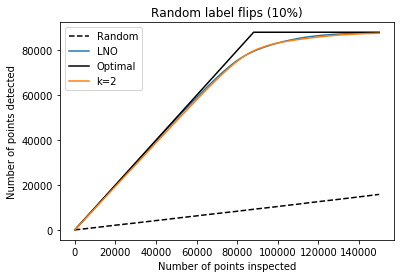

In [308]:
n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), optimal_list, 'k', label='Optimal')
plt.plot(range(n), kfold_list, label='k=2')
plt.xlabel('Number of points inspected')
plt.ylabel('Number of points detected')
plt.title('Random label flips (10%)')

plt.legend()

### More Mislabeled Data (20%)

In [162]:
y_train_new, error_train_array = flip_random_labels(y_train, frac=0.2)

In [163]:
t = sum([len(a) for a in error_train_array]); print('Num tags:', t)
e = sum([sum(a) for a in error_train_array]); print('Num errs:', e)
e/t

Num tags: 839711
Num errs: 174112


0.2073475278994797

In [159]:
crf.fit(X_train, y_train_new)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [160]:
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.5310515976436588


In [90]:
y_train_pred_probs = crf.predict_marginals(X_train)

In [91]:
scores = score_mislabeled(y_train_new, y_train_pred_probs)

In [92]:
random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=300000)

#### k=3

In [139]:
def score_kfold(X, y, k=2):
    """
    X: input features, as a numpy array
    y: input labels, as a numpy array
    k: the number of folds, as an integer (increasing k increases runtime)
    """
    X = np.array(X)
    y = np.array(y)
    
    n = X.shape[0]
    print('num samples:', n)
    assert n == y.shape[0]  # y needs to have the same number of samples as X
    
    indices = np.arange(n)
    shuffled_indices = np.random.permutation(n)
    all_scores = [[]] * n 
    
    print('{} folds:'.format(k), end=' ')
    for i in range(k):
        print(i, end=' ')
        start_idx = int(n*i/k)
        end_idx = int(n*(i+1)/k)
        indices_to_evaluate = shuffled_indices[start_idx:end_idx]
        
        mask_to_train = np.ones_like(indices, dtype=bool)
        mask_to_train[indices_to_evaluate] = False
        
        X_train = X[mask_to_train]
        y_train = y[mask_to_train]
        crf.fit(X_train, y_train)
        
        X_eval = X[~mask_to_train]
        y_eval = y[~mask_to_train]
        eval_indices = np.arange(n)[~mask_to_train]
        y_pred_probs = crf.predict_marginals(X_eval)
        
        for i in range(len(y_eval)):
            scores = []
            for j in range(len(y_eval[i])):
                prob_dict = y_pred_probs[i][j]
                max_prob_label = max(prob_dict, key=prob_dict.get)
                if max_prob_label == y_eval[i][j]:
                    scores.append(1 - prob_dict[max_prob_label])
                else:
                    scores.append(prob_dict[max_prob_label]) 
                        
            all_scores[eval_indices[i]] = scores
    
    return all_scores

In [146]:
kfold_scores = score_kfold(X_train, y_train_new, k=2)

num samples: 38367
2 folds: 0 1 

In [149]:
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=300000)

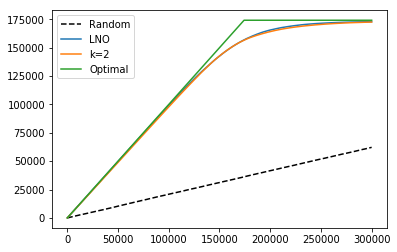

In [152]:
n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), kfold_list, label='k=2')
plt.plot(range(n), optimal_list, label='Optimal')
plt.legend()

### Even More Mislabeled Data (40%)

num samples: 38367
2 folds: 0 1 

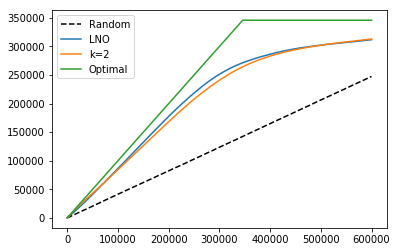

In [154]:
y_train_new, error_train_array = flip_random_labels(y_train, frac=0.4)
crf.fit(X_train, y_train_new)
y_train_pred_probs = crf.predict_marginals(X_train)
scores = score_mislabeled(y_train_new, y_train_pred_probs)
kfold_scores = score_kfold(X_train, y_train_new, k=2)

random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=600000)
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=600000)

n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), kfold_list, label='k=2')
plt.plot(range(n), optimal_list, label='Optimal')
plt.legend()

Out of curiosity...

In [157]:
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.4244156846555517


# More Systematic Mislabeling

## 'Missing' Labels (Things get labeled as O)

* The `B-x`is randomly flipped to a different `O`, and all of the following `I-x` are flipped as well to `O`

In [309]:
import copy, random

def insert_missing_labels(y, frac=0.25):
    y_new = []
    error_array = []
    
    counter = 0
    
    for i in range(len(y)):
        error_array.append(list())
        y_new.append(list())
        change_tag = False
        
        for j in range(len(y[i])):
            current_tag = y[i][j]

            if current_tag == 'O' and change_tag:  # stop flipping Ix --> Iy
                change_tag = False
                
            if change_tag and (current_tag.startswith('I-')):  # Ix --> Iy if a Bx tag has been changed to By
                y_new[i].append('O')
                error_array[i].append(True)
                continue                
            
            
            if not(current_tag == 'O') and np.random.random() < frac:
                error_array[i].append(True)
                y_new[i].append('O')
                change_tag = True
            else:
                error_array[i].append(False)
                y_new[i].append(current_tag)
        
    return y_new, error_array

In [310]:
y_train_new, error_train_array = insert_missing_labels(y_train, frac=0.1)

In [311]:
t = sum([len(a) for a in error_train_array]); print('Num tags:', t)
e = sum([sum(a) for a in error_train_array]); print('Num errs:', e)
e/t

Num tags: 839711
Num errs: 17774


0.02116680619879935

num samples: 38367
2 folds: 0 1 

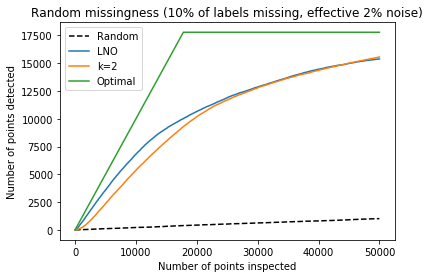

In [312]:
crf.fit(X_train, y_train_new)
y_train_pred_probs = crf.predict_marginals(X_train)
scores = score_mislabeled(y_train_new, y_train_pred_probs)
kfold_scores = score_kfold(X_train, y_train_new, k=2)

random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=50000)
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=50000)

n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), kfold_list, label='k=2')
plt.plot(range(n), optimal_list, label='Optimal')
plt.xlabel('Number of points inspected')
plt.ylabel('Number of points detected')
plt.title('Random missingness (10% of labels missing, effective 2% noise)')
plt.legend()

#### 25%

num samples: 38367
2 folds: 0 1 

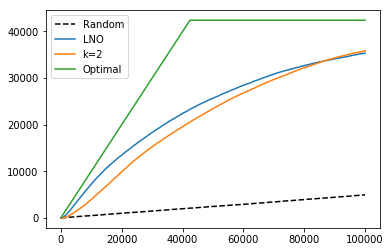

In [184]:
y_train_new, error_train_array = insert_missing_labels(y_train, frac=0.25)
crf.fit(X_train, y_train_new)
y_train_pred_probs = crf.predict_marginals(X_train)
scores = score_mislabeled(y_train_new, y_train_pred_probs)
kfold_scores = score_kfold(X_train, y_train_new, k=2)

random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=100000)
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=100000)

n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), kfold_list, label='k=2')
plt.plot(range(n), optimal_list, label='Optimal')
plt.legend()

In [185]:
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.52418645662776


In [186]:
t = sum([len(a) for a in error_train_array]); print('Num tags:', t)
e = sum([sum(a) for a in error_train_array]); print('Num errs:', e)
e/t

Num tags: 839711
Num errs: 42391


0.05048284469299557

## 'Low-Resolution' Labels (Some Surrounding Words Get Tagged)

* extended 50% of tags by 3 words on either side

In [313]:
import copy, random

def blur_labels(y, frac=0.25):
    y_new = []
    error_array = []
    
    counter = 0
    
    for i in range(len(y)):
        error_array.append(list())
        y_new.append(list())
        change_steps = 0
        change_to = None
        
        for j in range(len(y[i])):
            current_tag = y[i][j]
            if change_steps > 0:
                change_steps -= 1
                y_new[i].append(change_to)
                error_array[i].append(True)
                continue
            
            if current_tag.startswith('B') and np.random.random() < frac and j >= 3:
                new_tag = current_tag.replace('B', 'I')
                y_new[i][j - 3] = current_tag; error_array[i][j-3] = True
                y_new[i][j - 2] = new_tag; error_array[i][j-2] = True
                y_new[i][j - 1] = new_tag; error_array[i][j-1] = True
                y_new[i].append(new_tag); 
                error_array[i].append(False)
                
                if (len(y[i])-j)>3 and not(current_tag=='O') and y[i][j+1] == 'O' and np.random.random() < frac:
                    change_to = current_tag.replace('B', 'I')
                    change_steps = 3
                
                continue
            
            if (len(y[i])-j)>3 and not(current_tag=='O') and y[i][j+1] == 'O' and np.random.random() < frac:
                change_to = current_tag.replace('B', 'I')
                change_steps = 3
                y_new[i].append(current_tag); 
                error_array[i].append(False)
                continue
            
            error_array[i].append(False)
            y_new[i].append(current_tag)
        
    return y_new, error_array

In [314]:
y_train_new, error_train_array = blur_labels(y_train, frac=0.25)

In [316]:
t = sum([len(a) for a in error_train_array]); print('Num tags:', t)
e = sum([sum(a) for a in error_train_array]); print('Num errs:', e)
e/t

Num tags: 839711
Num errs: 95655


0.11391419190650116

num samples: 38367
2 folds: 0 1 

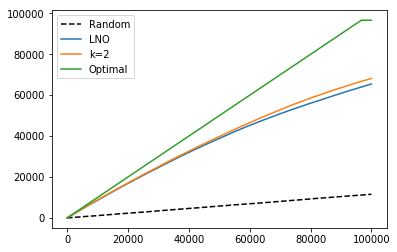

In [272]:
crf.fit(X_train, y_train_new)
y_train_pred_probs = crf.predict_marginals(X_train)
scores = score_mislabeled(y_train_new, y_train_pred_probs)
kfold_scores = score_kfold(X_train, y_train_new, k=2)

random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=100000)
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=100000)

n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), kfold_list, label='k=2')
plt.plot(range(n), optimal_list, label='Optimal')
plt.legend()

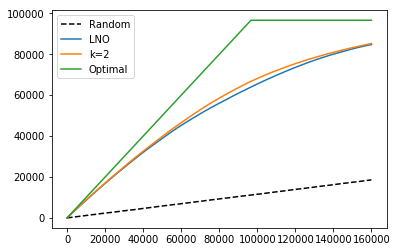

In [275]:
random_list, method_list, optimal_list = get_performance(scores, error_train_array, num_to_inspect=160000)
_, kfold_list, _ = get_performance(kfold_scores, error_train_array, num_to_inspect=160000)

n = len(random_list)

plt.plot(range(n), random_list, 'k--', label='Random')
plt.plot(range(n), method_list, label='LNO')
plt.plot(range(n), kfold_list, label='k=2')
plt.plot(range(n), optimal_list, label='Optimal')
plt.legend()

In [273]:
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.44994844103544074
